In [2]:
learning = {
  1: 'data (prepare and load)',
  2: 'build model',
  3: 'fitting the model to data (training)',
  4: 'making predictions and evaluating a model (inference)',
  5: 'saving and loading a model',
  6: 'putting it all together'
}

learning

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [3]:
import torch
from torch import nn # nn contains all the PyTorch's building blocks for graphs/neural network
import matplotlib.pyplot as plt

torch.__version__

'2.6.0.dev20241126'

## Data (preparing and loading)




use a linear regression formula to make a straight line with *known* **parameters**

In [4]:
# create known parameters
weight = 0.7
bias = 0.3

#create 
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

print(X.shape, y.shape)
X[:10], y[:10], len(X), len(y)

torch.Size([50, 1]) torch.Size([50, 1])


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and test sets 

In [5]:
train_split = int(0.8 * len(X))
# split the train
X_train, y_train=X[:train_split], y[:train_split]
# split the test
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
# visualize

def plot_predictions(train_data=X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, predictions=None):
  """
  plotting training data, testing data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=6, label="Training data")
  #plot testing data
  plt.scatter(test_data, test_labels, c = 'g', s=6, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c ='r', s = 7, label="Predictions")

  plt.legend(prop={"size": 14})
  plt.tight_layout()
  plt.show()


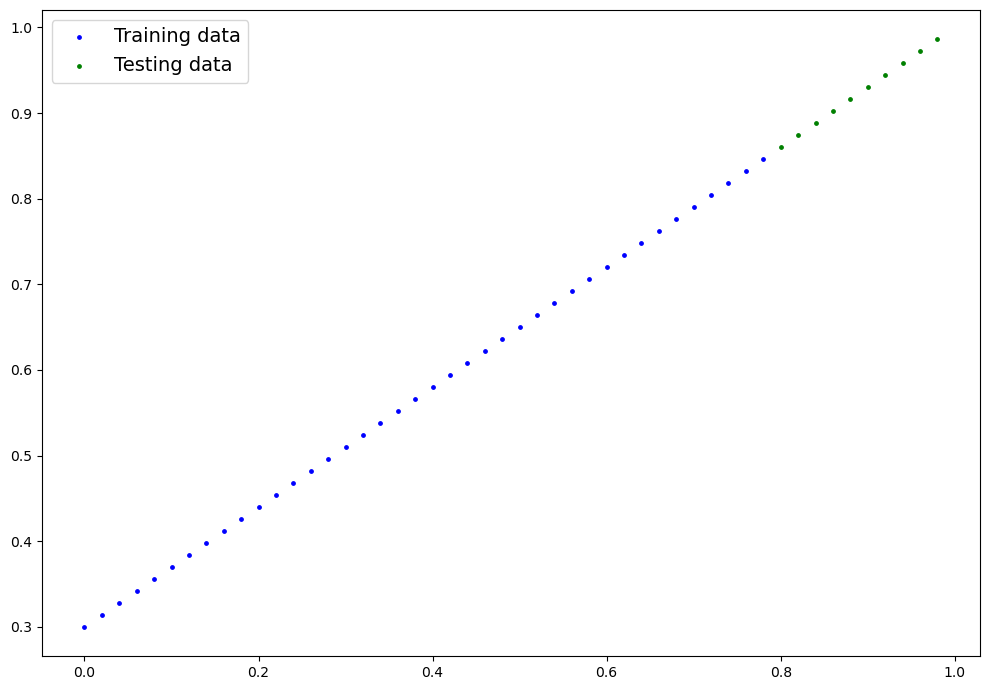

In [7]:
plot_predictions()

### PyTorch models are built using classes in python and are relatively follows a pipeline architecture rather than in Tensorflow and keras

* Start with random values (weights and biases)
* Look at the training data and adjust the random values to better represent (or get closer to) the ideal values (the weights and bias values we used to create the data).

In [8]:
class LinearRegression(nn.Module): # the Module class contains all the important neural network blocks required
  # define the constructor
  def __init__(self):
    super().__init__()
    # linear regression requires the weights and bias
    # create the weights parameter
    self.weights = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True)) # <- start with a random weight (gets adjusted as the model begins to learn)
    self.bias = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))

  # the forward means the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # 'x' is the input data (e.g: training/testing features) and returns a tensor
    return self.weights * x + self.bias  # linear regression: y = m*x + c


In [9]:
torch.manual_seed(53)

model_0 = LinearRegression()
model_0

LinearRegression()

In [10]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.7688], requires_grad=True),
 Parameter containing:
 tensor([-0.1738], requires_grad=True)]

In [11]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.7688])), ('bias', tensor([-0.1738]))])

In [12]:
weight, bias

(0.7, 0.3)

### Making Prediction using `torch.inference_mode()`

test how well it predicts 'y_test based on 'X_test'

In [13]:
with torch.inference_mode():
  y_preds = model_0(X_test)

# can also use `torch.no_grad()`, however torch.inference_mode() is preferred
# with torch.no_grad():
#   y_pred = model_0(X_test)

y_preds

tensor([[0.4412],
        [0.4566],
        [0.4720],
        [0.4874],
        [0.5027],
        [0.5181],
        [0.5335],
        [0.5489],
        [0.5642],
        [0.5796]])

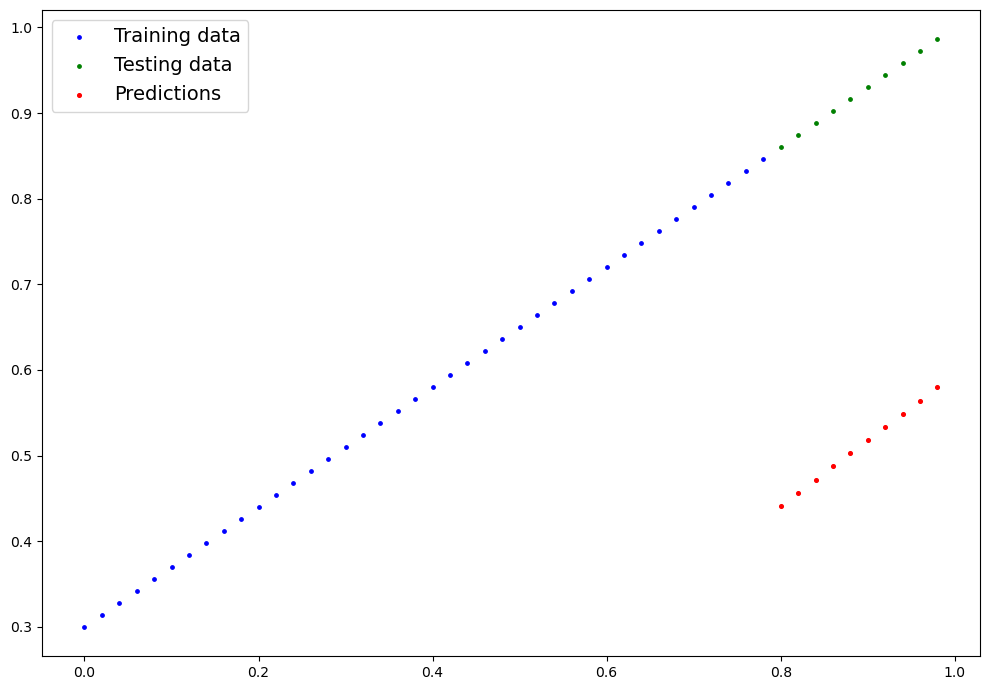

In [14]:
plot_predictions(predictions=y_preds)

# Train model
The whole idea of training is for a model to move from some "unknown" parameters (these may be random) to some "known" parameters

Or in other words from a poor representation of the data to a better representation of the data.

To measure how poor or wrong our models prediction is we can use something like the "Loss function".

* Note: Loss function in PyTorch referred to as "criterion" or maybe cost function.

Need for training:

* **Loss Function**: Function to measure how wrong our model's prediction are to that of the ideal outputs, (lower is better)
* **Optimizer**: Takes into account the loss of a model and adjust the model parameters accordingly (e.g: adjusts the weights and biases) to improve the loss function.

Optimizer takes two set of parameters:
  - `params`: the model parameters we want to optimize, eg - `params = model_0.parameters()`
  - `lr`: learning rate, which is a hyperparameter

In [15]:
print(list(model_0.parameters()))
print(model_0.state_dict())

[Parameter containing:
tensor([0.7688], requires_grad=True), Parameter containing:
tensor([-0.1738], requires_grad=True)]
OrderedDict([('weights', tensor([0.7688])), ('bias', tensor([-0.1738]))])


For pytorch we specifically need to make:
- Training loop
- Testing loop

In [16]:
# Setup the loss function
loss_fn = nn.L1Loss() # L1Loss = MAE (mean absolute error) i.e torch.mean(torch.abs(y_pred - y_test))

# set up optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [17]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## Building the training loop

- Loop through the data.
- Forward pass: data moving through the forward() function to make predictions on data - forward propagation
- Calculate the loss (compare forward pass predictions to ground truth labels)
- Optimizer zero grad
- Back Propagation: Loss backwards i.e, move backwards through the network to calculate the gradients of each of the parameters of our model w.r.t the loss.
- Optimizer step: use the optimizer to adjust our model's models parameter to try and improve the loss (gradient descent).


In [18]:
torch.manual_seed(42)
# epoch: one loop through the data (hyperparameter we have personally set up)
epochs = 300

#Tracking the values
epoch_count = []
loss_count = []
test_loss_count = []

# 1. Loop through the data
for epoch in range(epochs):
  # set the model to train mode
  model_0.train()

  # 2. Forward Pass 
  y_pred = model_0(X_train)

  # 3. Calculate the loss function (input, target) -> y_pred, y_true
  loss = loss_fn(y_pred, y_train)
  # print(f"Loss: {loss}")

  # 4. optimizer zero grad -> done to initialize optimizer to zero everytime the loop executes
  optimizer.zero_grad()

  # 5. Back Propagation
  loss.backward()

  # 6. gradient descent step
  optimizer.step()

  #testing
  model_0.eval() # turns off different settings in the model not needed for evaluating/testing (dropout/batch norm)
  with torch.inference_mode():
    # 1. Forward Pass
    test_pred = model_0(X_test)
    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)
    # Print - epoch, loss, test loss
  if(epoch % 10 == 0):
    epoch_count.append(epoch)
    loss_count.append(loss)
    test_loss_count.append(test_loss)
    print(f"Epochs: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
      
    print(model_0.state_dict())

Epochs: 0 | Loss: 0.4469829499721527 | Test Loss: 0.3991061747074127
OrderedDict([('weights', tensor([0.7727])), ('bias', tensor([-0.1638]))])
Epochs: 10 | Loss: 0.33177298307418823 | Test Loss: 0.26439619064331055
OrderedDict([('weights', tensor([0.8117])), ('bias', tensor([-0.0638]))])
Epochs: 20 | Loss: 0.21656303107738495 | Test Loss: 0.12968631088733673
OrderedDict([('weights', tensor([0.8507])), ('bias', tensor([0.0362]))])
Epochs: 30 | Loss: 0.10135307163000107 | Test Loss: 0.01011087279766798
OrderedDict([('weights', tensor([0.8897])), ('bias', tensor([0.1362]))])
Epochs: 40 | Loss: 0.044669538736343384 | Test Loss: 0.07866481691598892
OrderedDict([('weights', tensor([0.9028])), ('bias', tensor([0.1982]))])
Epochs: 50 | Loss: 0.03901422768831253 | Test Loss: 0.08644921332597733
OrderedDict([('weights', tensor([0.8908])), ('bias', tensor([0.2167]))])
Epochs: 60 | Loss: 0.03548610955476761 | Test Loss: 0.08229811489582062
OrderedDict([('weights', tensor([0.8749])), ('bias', tenso

In [19]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.7047])), ('bias', tensor([0.2942]))])

In [20]:
weight, bias

(0.7, 0.3)

## Previous `y_preds` without training the model

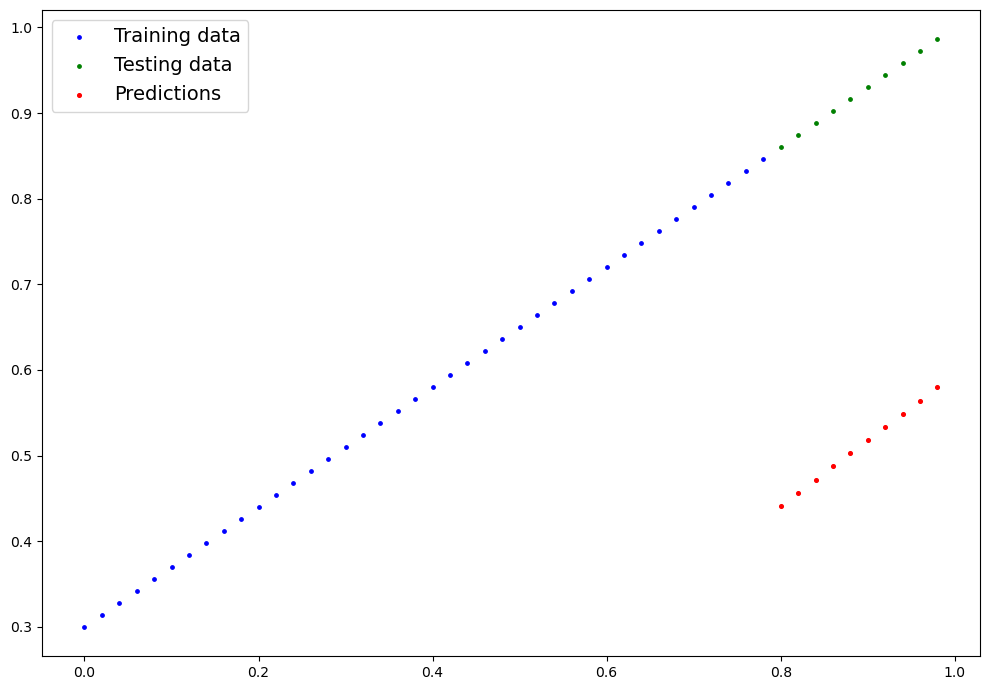

In [21]:
plot_predictions(predictions=y_preds)

## After training the model and testing it

In [22]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

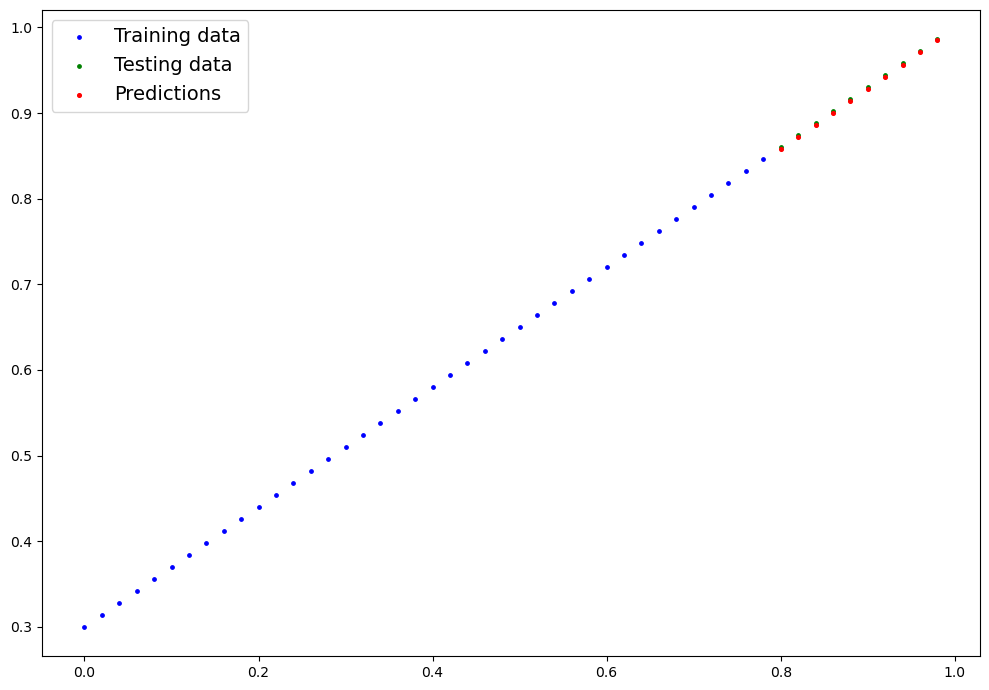

In [23]:
plot_predictions(predictions=y_preds_new)

In [24]:
epoch_count, test_loss_count, loss_count

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250,
  260,
  270,
  280,
  290],
 [tensor(0.3991),
  tensor(0.2644),
  tensor(0.1297),
  tensor(0.0101),
  tensor(0.0787),
  tensor(0.0864),
  tensor(0.0823),
  tensor(0.0740),
  tensor(0.0664),
  tensor(0.0582),
  tensor(0.0499),
  tensor(0.0423),
  tensor(0.0340),
  tensor(0.0258),
  tensor(0.0182),
  tensor(0.0099),
  tensor(0.0119),
  tensor(0.0119),
  tensor(0.0119),
  tensor(0.0119),
  tensor(0.0119),
  tensor(0.0119),
  tensor(0.0119),
  tensor(0.0119),
  tensor(0.0119),
  tensor(0.0119),
  tensor(0.0119),
  tensor(0.0119),
  tensor(0.0119),
  tensor(0.0119)],
 [tensor(0.4470, grad_fn=<MeanBackward0>),
  tensor(0.3318, grad_fn=<MeanBackward0>),
  tensor(0.2166, grad_fn=<MeanBackward0>),
  tensor(0.1014, grad_fn=<MeanBackward0>),
  tensor(0.0447, grad_fn=<MeanBackward0>),
  tensor(0.0390, grad_fn=<MeanBackward0>),
 

In [25]:
# Converting the loss count and test loss count tensors to numpy array
import numpy as np

loss_count = np.array(torch.tensor(loss_count).numpy())
loss_count

test_loss_count = np.array(torch.tensor(test_loss_count).numpy())
test_loss_count

array([0.39910617, 0.2643962 , 0.12968631, 0.01011087, 0.07866482,
       0.08644921, 0.08229811, 0.07402562, 0.06644005, 0.05816757,
       0.04989502, 0.04230936, 0.03403683, 0.02576429, 0.01817864,
       0.00990608, 0.01186112, 0.01186112, 0.01186112, 0.01186112,
       0.01186112, 0.01186112, 0.01186112, 0.01186112, 0.01186112,
       0.01186112, 0.01186112, 0.01186112, 0.01186112, 0.01186112],
      dtype=float32)

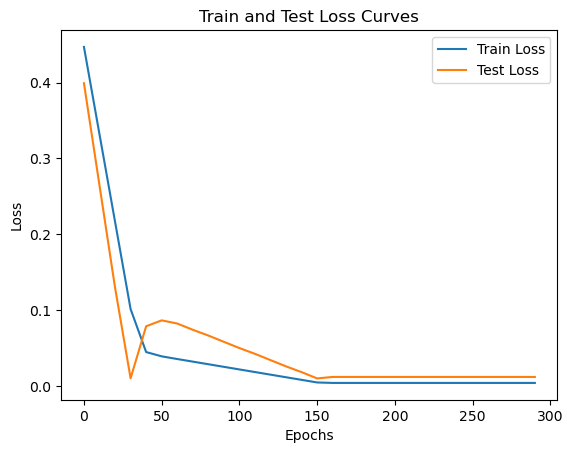

In [26]:
# Plotting the loss curve
import numpy as np

plt.plot(epoch_count, loss_count, label="Train Loss")
plt.plot(epoch_count, test_loss_count, label="Test Loss")
plt.title("Train and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Saving a model in PyTorch

3 main methods of saving and loading model:

- `torch.save()` - save a pytorch object in python pickle format
- `torch.load()` - load a saved pytorch object
- `torch.nn.Module.load_state_dict()` - load a model's saved state dictionary


In [27]:
from pathlib import Path

MODEL_PATH = Path("saved_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME="01_pytorch_workflow_LinearRegressionModel.pt"
MODEL_SAVE_PATH=MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH
print(f"Saving our model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving our model to: saved_models/01_pytorch_workflow_LinearRegressionModel.pt


In [28]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.7047])), ('bias', tensor([0.2942]))])

In [29]:
# Loading our saved model

# 1. To load a state dict, we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegression()
# updates the new instance with updated parameters
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [30]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.7047])), ('bias', tensor([0.2942]))])

In [31]:
# Make prediction
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8580],
        [0.8721],
        [0.8862],
        [0.9002],
        [0.9143],
        [0.9284],
        [0.9425],
        [0.9566],
        [0.9707],
        [0.9848]])

In [32]:
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting everything together

In [66]:
import torch
from torch import nn
import matplotlib.pyplot as plt

print(torch.__version__)
# check gpu configuration / device agnostic code
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Current device using: {device}")
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

2.6.0.dev20241126
Current device using: mps
True
True


## Create the data

In [67]:
# creating data using Linear regression formula y = m*x + c
weight = 0.6
bias = 0.4
start = 0
end = 1
step = 0.02

# X->feature | y->label
X = torch.arange(start, end, step).unsqueeze(dim=1)
y=weight*X + bias
X[:10], y[:10]
train_split=int(0.8*len(X))
print(X.shape, y.shape)
print("Splitting the data into train sets...\n")
X_train, y_train = X[:train_split], y[:train_split]
print(f"X_train = {len(X_train)}, y_train = {len(y_train)}\n")
print("Splitting the data into test sets...\n")
X_test, y_test=X[train_split:], y[train_split:]
print(f"X_test = {len(X_test)}, y_test = {len(y_test)}")

torch.Size([50, 1]) torch.Size([50, 1])
Splitting the data into train sets...

X_train = 40, y_train = 40

Splitting the data into test sets...

X_test = 10, y_test = 10


In [68]:
def plot_predictions(train_data=X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, predictions=None):
  """
  plotting training data, testing data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=6, label="Training data")
  #plot testing data
  plt.scatter(test_data, test_labels, c = 'g', s=6, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c ='r', s = 7, label="Predictions")

  plt.legend(prop={"size": 14})
  plt.tight_layout()
  plt.show()

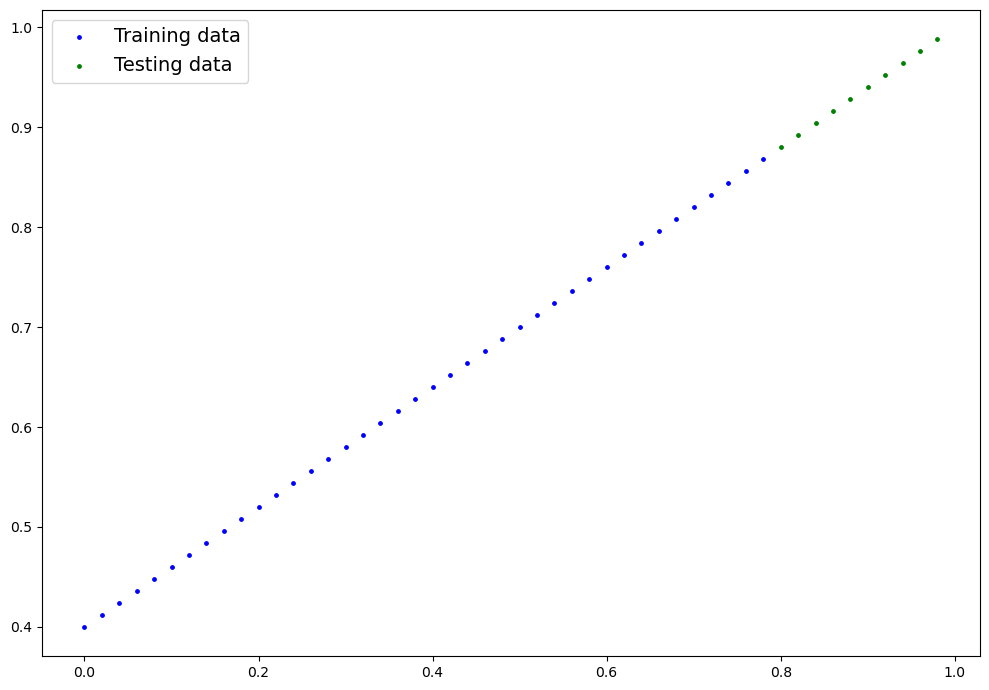

In [69]:
plot_predictions(X_train, y_train, X_test, y_test)

In [70]:
# Building the linear model
class LinearRegressionModelv2(nn.Module):
  def __init__(self):
    super().__init__()
    # use nn.linear() for creating the model parameters | probing layer | fully connected layer | dense layer in Tensorflow all same name for Linear Layer
    # torch.nn.Linear() applies a linear transformation to the incoming data: y = x * A^T + b
    # in_features : size of each input sample
    # out_features : size of each output sample
    # bias : If False, layer won't learn any additive bias
    self.linear_layer = nn.Linear(in_features=1, out_features=1) # take input of 1 feature X and output 1 feature y

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_v2 = LinearRegressionModelv2()
model_v2, model_v2.state_dict()

(LinearRegressionModelv2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

## Without training, check the plot

tensor([[1.4416],
        [1.4569],
        [1.4722],
        [1.4875],
        [1.5028],
        [1.5181],
        [1.5334],
        [1.5487],
        [1.5640],
        [1.5793]])


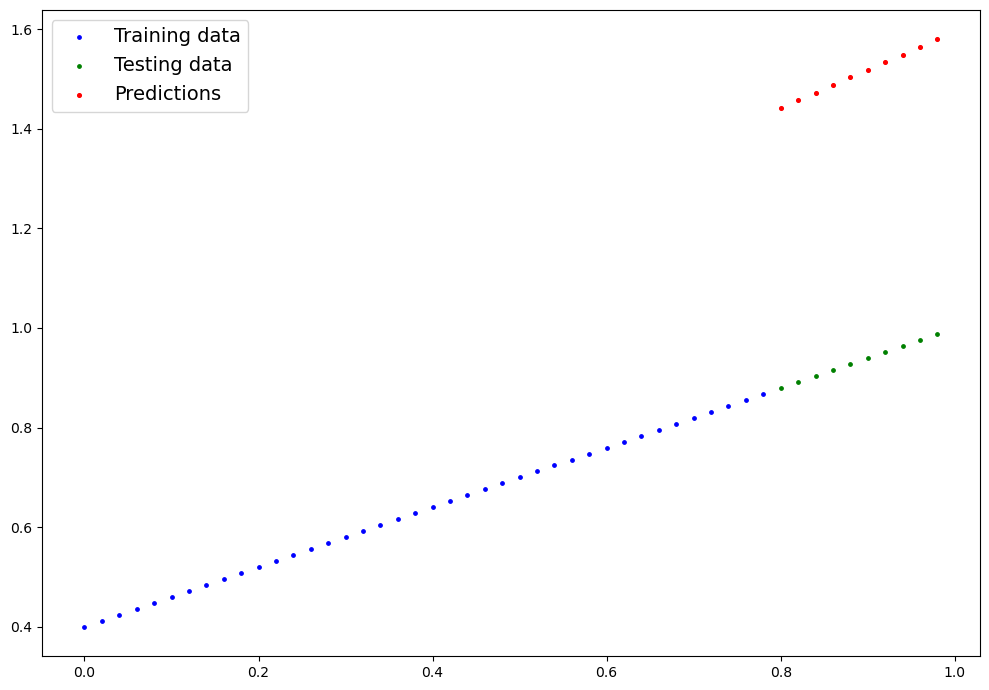

In [71]:
with torch.inference_mode():
  y_preds_notraining = model_v2(X_test)

print(y_preds_notraining)
plot_predictions(predictions=y_preds_notraining.cpu())

In [72]:
# check model device
print(next(model_v2.parameters()).device)
# send the model to gpu ie mps here
model_v2.to(device)
print(next(model_v2.parameters()).device)

cpu
mps:0


## Training
- Loss function
- Optimizer
- Training Loop
- Testing loop

In [73]:
loss_function = nn.L1Loss() # MAE
sgd_optimizer = torch.optim.SGD(params=model_v2.parameters(), lr=0.01)

In [74]:
# Training Loop
torch.manual_seed(42)

epoch_list = []
trainLoss_list = []
testLoss_list = []

# device agnostic code for data
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

epochs = 200
for epoch in range(epochs):
  # training
  model_v2.train()
  y_prediction = model_v2(X_train)
  loss=loss_function(y_prediction, y_train)
  sgd_optimizer.zero_grad()
  loss.backward()
  sgd_optimizer.step()

  #testing
  model_v2.eval()
  with torch.inference_mode():
    # forward pass
    y_test_pred = model_v2(X_test)
    # calculate the test loss
    test_loss = loss_function(y_test_pred, y_test)

  # print out the values 
  if(epoch % 10 == 0):
    epoch_list.append(epoch)
    trainLoss_list.append(loss)
    testLoss_list.append(test_loss)
    print(f"Epochs: {epoch} | Train Loss = {loss} | Test Loss = {test_loss}")
    print(model_v2.state_dict())


Epochs: 0 | Train Loss = 0.494177907705307 | Test Loss = 0.5629763007164001
OrderedDict([('linear_layer.weight', tensor([[0.7606]], device='mps:0')), ('linear_layer.bias', tensor([0.8200], device='mps:0'))])
Epochs: 10 | Train Loss = 0.3789680600166321 | Test Loss = 0.42826637625694275
OrderedDict([('linear_layer.weight', tensor([[0.7216]], device='mps:0')), ('linear_layer.bias', tensor([0.7200], device='mps:0'))])
Epochs: 20 | Train Loss = 0.26375818252563477 | Test Loss = 0.2935565412044525
OrderedDict([('linear_layer.weight', tensor([[0.6826]], device='mps:0')), ('linear_layer.bias', tensor([0.6200], device='mps:0'))])
Epochs: 30 | Train Loss = 0.14854831993579865 | Test Loss = 0.15884672105312347
OrderedDict([('linear_layer.weight', tensor([[0.6436]], device='mps:0')), ('linear_layer.bias', tensor([0.5200], device='mps:0'))])
Epochs: 40 | Train Loss = 0.033338434994220734 | Test Loss = 0.024136876687407494
OrderedDict([('linear_layer.weight', tensor([[0.6046]], device='mps:0')), ('

In [75]:
print(f"Original weight: {weight} and bias: {bias}")
model_v2.state_dict()

Original weight: 0.6 and bias: 0.4


OrderedDict([('linear_layer.weight', tensor([[0.6007]], device='mps:0')),
             ('linear_layer.bias', tensor([0.4095], device='mps:0'))])

### Before training the model using linear layer

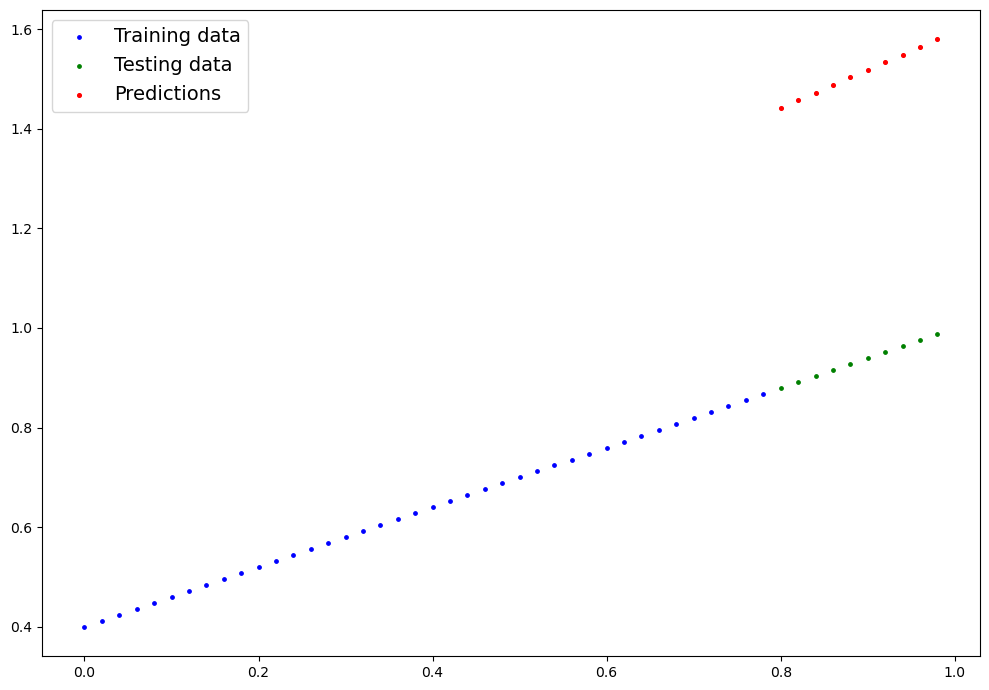

In [79]:
plot_predictions(predictions=y_preds_notraining)

tensor([[0.8901],
        [0.9021],
        [0.9141],
        [0.9261],
        [0.9382],
        [0.9502],
        [0.9622],
        [0.9742],
        [0.9862],
        [0.9982]], device='mps:0')


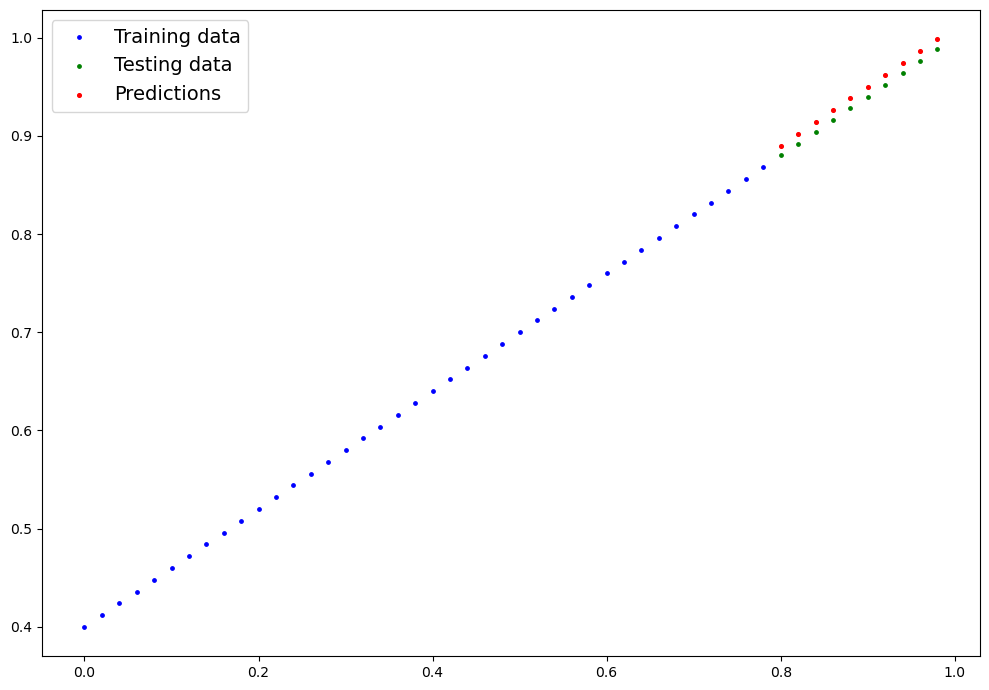

In [ ]:
model_v2.eval()

with torch.inference_mode():
  y_test_pred = model_v2(X_test)

print(y_test_pred)
plot_predictions(predictions=y_test_pred.cpu())

In [ ]:
epoch_list, testLoss_list, trainLoss_list
import numpy as np
testLoss_list = np.array(torch.tensor(testLoss_list).numpy())

trainLoss_list = np.array(torch.tensor(trainLoss_list).numpy())

[0.4941779  0.37896806 0.26375818 0.14854832 0.03333843 0.00979647
 0.00979647 0.00979647 0.00979647 0.00979647 0.00979647 0.00979647
 0.00979647 0.00979647 0.00979647 0.00979647 0.00979647 0.00979647
 0.00979647 0.00979647]


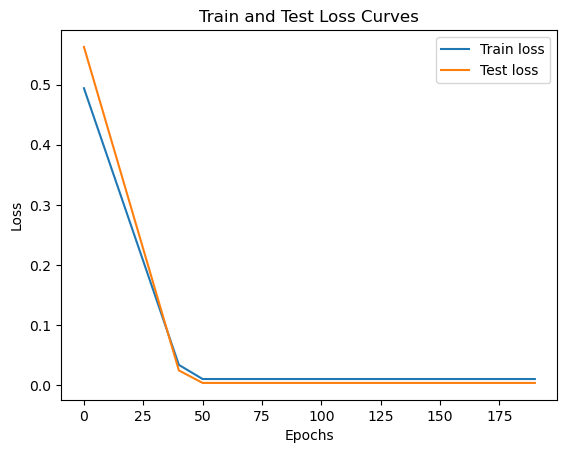

In [84]:
#Loss graph
plt.plot(epoch_list, trainLoss_list, label="Train loss")
plt.plot(epoch_list, testLoss_list, label="Test loss")
plt.title("Train and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Saving the model

In [92]:
from pathlib import Path

MODEL_PATH = Path("saved_models")
MODEL_PATH.mkdir(parents=True, exist_ok = True)
MODEL_NAME="01_linearRegressionV2.pt"
MODEL_SAVE_PATH= MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH
torch.save(obj=model_v2.state_dict(), f=MODEL_SAVE_PATH)

In [99]:
print(model_v2.state_dict())

loaded_model_v2 = LinearRegressionModelv2()
print(loaded_model_v2.load_state_dict(torch.load(f=MODEL_SAVE_PATH)))
loaded_model_v2.to(device)
print(next(loaded_model_v2.parameters()).device)
print(loaded_model_v2.state_dict())


OrderedDict([('linear_layer.weight', tensor([[0.6007]], device='mps:0')), ('linear_layer.bias', tensor([0.4095], device='mps:0'))])
<All keys matched successfully>
mps:0
OrderedDict([('linear_layer.weight', tensor([[0.6007]], device='mps:0')), ('linear_layer.bias', tensor([0.4095], device='mps:0'))])


In [101]:
# Evaluate the loaded model
loaded_model_v2.eval()
with torch.inference_mode():
  loaded_model_v2_preds = loaded_model_v2(X_test)

y_preds_new == loaded_model_v2_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')